In [9]:
import os
import csv

#os.chdir(r'C:\My\x2\180617\_merge')
mypath = os.getcwd()
print(mypath)

D:\_PlayGround\Github\pg\_chaos


In [10]:
infile_name = '20180617.csv'
infile_name = '180617_19-50-00.327.csv'

###### data preview

In [11]:
with open(infile_name, encoding='utf8') as csvf:
    rd = csv.reader(csvf, delimiter=',')
    for idx, line in enumerate(rd):
        print(line)
        
        if idx > 10:
            break

['0', '2018-06-17 195000.327002', '0.060999', '2.448898', '2.550633', '2.465567', '100', '1']
['1', '2018-06-17 195000.327004', '0.060352', '2.448898', '2.549986', '2.46589', '100', '1']
['2', '2018-06-17 195000.327006', '0.059705', '2.448898', '2.549016', '2.46589', '100', '1']
['3', '2018-06-17 195000.327008', '0.059058', '2.448898', '2.547723', '2.466536', '100', '1']
['4', '2018-06-17 195000.327010', '0.058411', '2.449222', '2.548369', '2.467829', '100', '1']
['5', '2018-06-17 195000.327012', '0.057441', '2.449222', '2.548046', '2.468152', '100', '1']
['6', '2018-06-17 195000.327014', '0.057441', '2.449545', '2.547723', '2.468798', '100', '1']
['7', '2018-06-17 195000.327016', '0.056793', '2.449545', '2.547723', '2.469122', '100', '1']
['8', '2018-06-17 195000.327018', '0.056146', '2.450839', '2.547399', '2.469445', '100', '1']
['9', '2018-06-17 195000.327020', '0.055823', '2.45181', '2.547399', '2.469768', '100', '1']
['10', '2018-06-17 195000.327022', '0.054852', '2.452781', '2.5

###### loading data

In [14]:
import pandas as pd
import numpy as np

names = ['idx', 'reg_date', 'gold', 'silver_u', 'silver_v', 'silver_w', 'hz', 'ch']
df = pd.read_csv(infile_name, sep=',', names=names)
# df = df.sample(frac=1)  # random sampling

In [33]:
df.shape[0]

25000

###### model - poly reg

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


training_set_size = 20000
test_set_size = 3000

training_set_X = df[['silver_u', 'silver_w', 'silver_v']].values.reshape(-1,3)[0:training_set_size, :]
training_set_y = df[['gold']][0:training_set_size].values.reshape(-1, 1) / 5 * 1000

test_set_X = df[['silver_u', 'silver_w', 'silver_v']].values.reshape(-1,3)[training_set_size:(training_set_size+test_set_size), :]
test_set_y = df[['gold']][training_set_size:(training_set_size+test_set_size)].values.reshape(-1, 1) / 5 * 1000

poly = PolynomialFeatures(degree=3)
training_set_X_poly_reg = poly.fit_transform(training_set_X)
test_set_X_poly_reg = poly.fit_transform(test_set_X)

model_poly_reg = LinearRegression()
model_poly_reg.fit(training_set_X_poly_reg, training_set_y)
test_set_pred_poly_reg = model_poly_reg.predict(test_set_X_poly_reg)

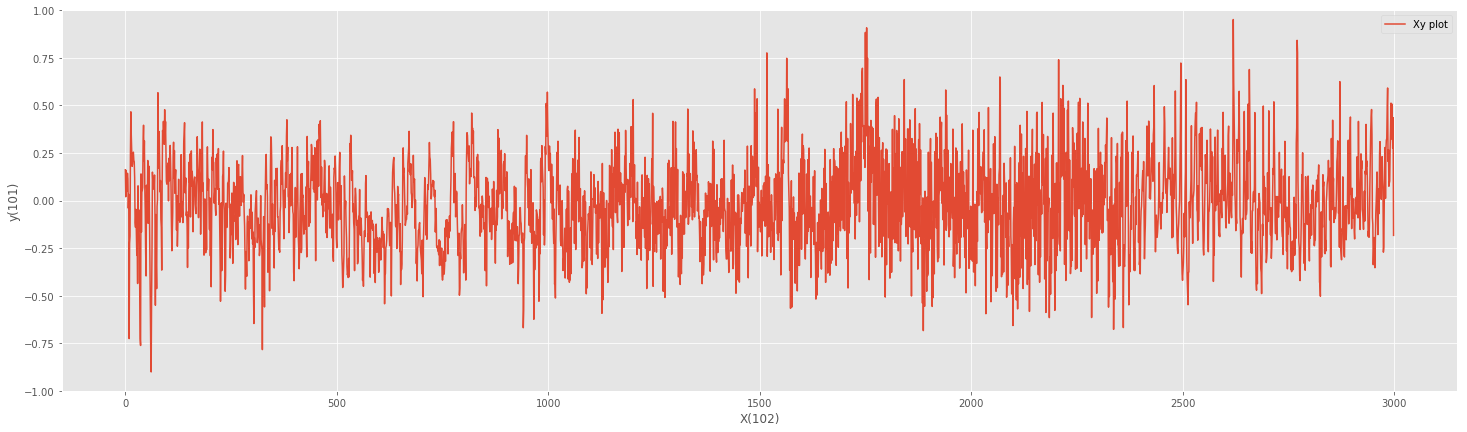

mse: 0.0561722186583  abs max: 0.951398725104  abs avg: 0.188118909809


In [98]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
plt.ylim(ymax=1, ymin=-1)
plt_x = range(len(test_set_X[:, 0]))
plt.plot(plt_x, (test_set_y - pred_poly_reg), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()


print('mse:', mean_squared_error(test_set_y, test_set_pred_poly_reg),
      ' abs max:', np.max(np.abs(test_set_y - test_set_pred_poly_reg)),
      ' abs avg:', np.average(np.abs(test_set_y - test_set_pred_poly_reg)))

###### model - dnn

In [154]:
import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def reset_graph(seed=1):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def get_tranformed_X(X, useShuffle=False):
    print('input shape:', X.shape, ', useShuffle:', useShuffle)
    scaler = MinMaxScaler(feature_range=(-1 + 1e-5, 1 - 1e-5))
    scaler.fit(X)
    X_arcsin = np.arcsin(scaler.transform(X))
    X_sin = np.sin(scaler.transform(X))
    X_arccos = np.arccos(scaler.transform(X))
    X_cos = np.cos(scaler.transform(X))
    
    X_out = np.concatenate((X_cos, X_arccos), axis=1) 
    if useShuffle:
        np.random.shuffle(X_out)
        
    print('output shape:', X_out.shape)
    return X_out


def show_performance_metrics(X, actual_y, save_path):

    def get_prediction():
        with tf.Session() as sess:
            tf.train.Saver().restore(sess, save_path)
            return sess.run(output_layer, feed_dict={input_layer: X})
    
    def plot_error(X, y_pred):
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (25,7)
        plt.ylim(ymax=5, ymin=-5)
        plt_x = range(X.shape[0])
        plt.plot(plt_x, (actual_y - y_pred), label='Xy plot')
        plt.xlabel('X(102)')
        plt.ylabel('y(101)')
        plt.legend()
        plt.show()

    y_pred = get_prediction()
    plot_error(X, y_pred)
    
    print('mse:', mean_squared_error(actual_y, y_pred),
          ' abs max:', np.max(np.abs(actual_y - y_pred)),
          ' abs avg:', np.average(np.abs(actual_y - y_pred)))

###### building data sets

In [160]:
reset_graph()

training_set_X_dnn = get_tranformed_X(training_set_X, useShuffle=False)
training_set_y_dnn = training_set_y

test_set_X_dnn = get_tranformed_X(test_set_X, useShuffle=False)
test_set_y_dnn = test_set_y

input shape: (20000, 3) , useShuffle: False
output shape: (20000, 6)
input shape: (3000, 3) , useShuffle: False
output shape: (3000, 6)


In [161]:
reset_graph()

training_set_X_dnn = training_set_X_poly_reg
training_set_y_dnn = training_set_y

test_set_X_dnn = test_set_X_poly_reg
test_set_y_dnn = test_set_y

In [162]:
learning_rate = 0.01
n_input = training_set_X_dnn.shape[1]
n_hidden = 6
n_epochs = 1000
now = datetime.now().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
he_init = tf.contrib.layers.variance_scaling_initializer()  

with tf.name_scope('y') as scope:
    y = tf.placeholder(dtype=tf.int64, shape=[None, 1], name='y')

with tf.name_scope('dnn'):
    input_layer = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name='X')
    hidden = tf.layers.dense(inputs=input_layer,      units=n_hidden, activation=None, kernel_initializer=he_init, name='hidden1')
    # hidden = tf.layers.dense(inputs=input_layer,      units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden1')
    # hidden = tf.layers.dense(inputs=hidden, units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden2')
    # hidden = tf.layers.dense(inputs=hidden, units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden3')
    output_layer = tf.layers.dense(inputs=hidden, units=1)
    
with tf.name_scope('loss'):
    loss = tf.losses.mean_squared_error(y, output_layer)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    
saver = tf.train.Saver()
save_path = '{}/run-{}/'.format(root_logdir, now, now) + 'model-session.ckpt'

In [166]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for i, epoch in enumerate(range(n_epochs)):
        _, loss_val = sess.run([train_op, loss], feed_dict={input_layer: training_set_X_dnn, y:training_set_y_dnn})
        if i % 100 == 0:
            print('Epoch[{}]:'.format(epoch), loss_val)
    
    _save_path = saver.save(sess, save_path)

Epoch[0]: 5442.82
Epoch[100]: 5.47195
Epoch[200]: 5.20822
Epoch[300]: 4.92141
Epoch[400]: 4.60388
Epoch[500]: 4.27288
Epoch[600]: 3.94226
Epoch[700]: 3.62325
Epoch[800]: 3.32471
Epoch[900]: 3.05327


INFO:tensorflow:Restoring parameters from tf_logs/run-20180628131126/model-session.ckpt


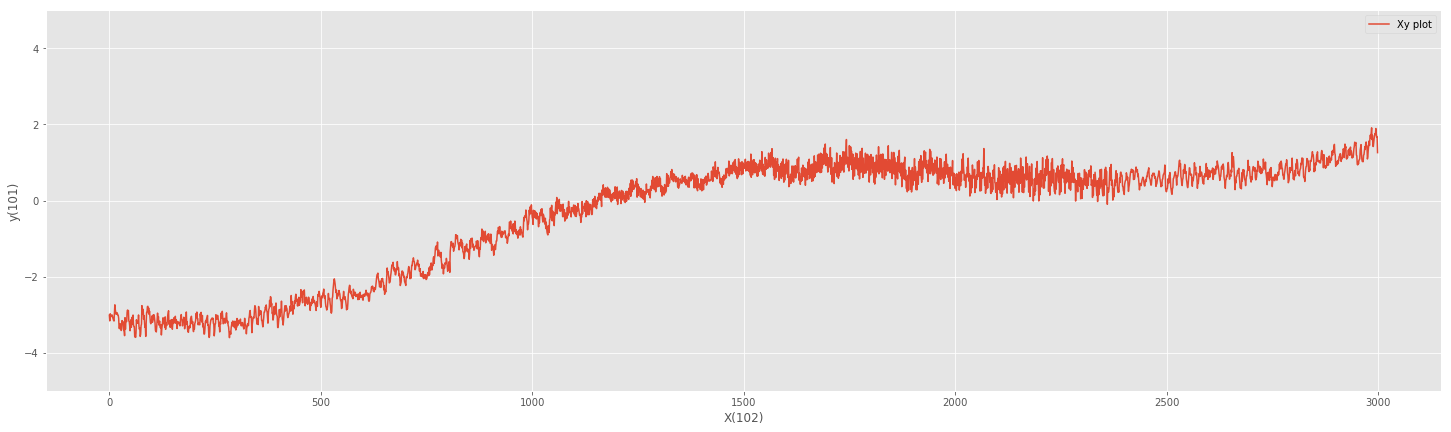

mse: 2.50345001914  abs max: 3.60360914917  abs avg: 1.2404280106


In [167]:
show_performance_metrics(test_set_X_dnn, test_set_y_dnn, save_path)